# On-Chain Metrics & Price

### Goals:
#### Using classification models, is it possible to estimate whether ETH will rise or fall over various time periods?
#### Aggregate different classification models with documentation links for easy reference.

In [188]:
#Imports 
import numpy as np
import pandas as pd
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Glassnode API to create a dataframe. 

API_KEY = '2AWlM3FJda1LoK0Eq4pDADN96d6'

urls = ['https://api.glassnode.com/v1/metrics/addresses/count',
       'https://api.glassnode.com/v1/metrics/addresses/active_count',
       'https://api.glassnode.com/v1/metrics/addresses/new_non_zero_count',
       'https://api.glassnode.com/v1/metrics/fees/gas_used_sum', 
       'https://api.glassnode.com/v1/metrics/market/price_usd_close']

data = []
for url in urls:
    label = url.split('/')[-1]
    res = requests.get(url, params = {'a':'ETH','api_key':API_KEY})
    df = pd.read_json(res.text, convert_dates=['t'])
    df.set_index('t', inplace = True)
    df.rename(columns = {'v':label}, inplace = True)
    data.append(df)
eth_df = pd.concat(data, axis=1)

In [3]:
# Checking to make sure nan values are limited in order to ensure the completeness of the df
for column in eth_df:
    print(f'{eth_df[column]} has {eth_df[column].isna().sum()} nan values')

t
2015-07-30         9203.0
2015-07-31         9359.0
2015-08-01         9474.0
2015-08-02         9561.0
2015-08-03         9637.0
                 ...     
2022-06-17    154732119.0
2022-06-18    154800269.0
2022-06-19    154861838.0
2022-06-20    154927479.0
2022-06-21            NaN
Freq: D, Name: count, Length: 2519, dtype: float64 has 1 nan values
t
2015-07-30         0.0
2015-07-31         0.0
2015-08-01         0.0
2015-08-02         0.0
2015-08-03         0.0
                ...   
2022-06-17    480403.0
2022-06-18    446177.0
2022-06-19    434371.0
2022-06-20    443537.0
2022-06-21         NaN
Freq: D, Name: active_count, Length: 2519, dtype: float64 has 1 nan values
t
2015-07-30     9203.0
2015-07-31      156.0
2015-08-01      115.0
2015-08-02       87.0
2015-08-03       76.0
               ...   
2022-06-17    68749.0
2022-06-18    68150.0
2022-06-19    61569.0
2022-06-20    65641.0
2022-06-21        NaN
Freq: D, Name: new_non_zero_count, Length: 2519, dtype: float64 has 1 

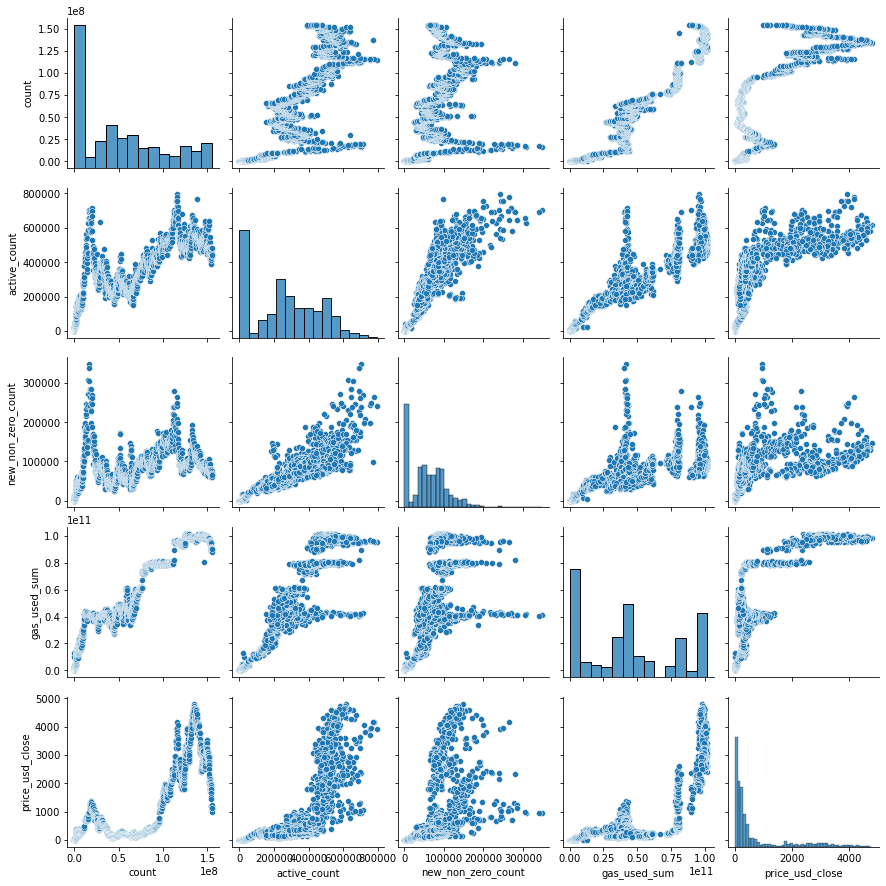

In [258]:
#Dropping nan values after 
#confirming it won't severly limit the quality of data
eth_df = eth_df.dropna()
#Plotting variables against each each other
sns.pairplot(eth_df.loc[:, :'price_usd_close'])

In [259]:
eth_df.describe()

,count,active_count,new_non_zero_count,gas_used_sum,price_usd_close,eth_price_increase_1d,eth_price_increase_7d,eth_price_increase_1m,eth_price_increase_3m,eth_price_increase_6m,eth_price_increase_1y
count,2.509000e+03,2509.000000,2509.000000,2.509000e+03,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,5.222024e+07,266136.153049,61744.595855,4.378600e+10,760.907105,0.510562,0.532483,0.559585,0.597449,0.651654,0.611798
std,4.882498e+07,192786.001516,50412.570421,3.435261e+10,1134.196998,0.499988,0.499043,0.496536,0.490509,0.476541,0.487438
min,1.064100e+04,731.000000,44.000000,3.886300e+07,0.435683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.311245e+06,42604.000000,12801.000000,3.918434e+09,53.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.380560e+07,261175.000000,57771.000000,4.140338e+10,230.926017,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.634846e+07,424053.000000,91165.000000,7.865057e+10,721.238000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.549275e+08,794922.000000,348434.000000,1.015230e+11,4819.010984,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Why Plot and Print these ^^?
- This is a very shallow version of exploratory data analysis. It is meant to show relationships, summarize main characteristics of the data, bolster understanding of the data and ultimately generate questions about the utility that may be extracted from the data. 

In [5]:
#Finding the difference between i eth_price and i.shift(1 day (1d), 7 day(7d), 1 month (1m), 3 month (3m)) eth_price. 
diff_eth_price_1d = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(1)
diff_eth_price_7d = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(7)
diff_eth_price_1m = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(30)
diff_eth_price_3m = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(90)

# adding difference in price to the data frame. Commented out because it bloats the width of the df
#eth_df['diff_eth_price_1d'] = diff_eth_price_1d
#eth_df['diff_eth_price_7d'] = diff_eth_price_7d
#eth_df['diff_eth_price_1m'] = diff_eth_price_1m
#eth_df['diff_eth_price_3m'] = diff_eth_price_3m


#Creating binary labels for increase in eth price over timeframes & adding to Df
eth_price_increase_1d = diff_eth_price_1d > 0
eth_df['eth_price_increase_1d'] = eth_price_increase_1d.astype(int)
eth_price_increase_7d = diff_eth_price_7d > 0
eth_df['eth_price_increase_7d'] = eth_price_increase_7d.astype(int)
eth_price_increase_1m = diff_eth_price_1m > 0
eth_df['eth_price_increase_1m'] = eth_price_increase_1m.astype(int)
eth_price_increase_3m = diff_eth_price_3m > 0
eth_df['eth_price_increase_3m'] = eth_price_increase_3m.astype(int)

In [203]:
test_df = eth_df.copy()
#Finding the difference between i eth_price and i.shift(1 day (1d), 7 day(7d), 1 month (1m), 3 month (3m)) eth_price. 
diff_eth_price_1d = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(-1)
diff_eth_price_7d = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(-7)
diff_eth_price_1m = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(-30)
diff_eth_price_3m = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(-90)

# adding difference in price to the data frame. Commented out because it bloats the width of the df
#eth_df['diff_eth_price_1d'] = diff_eth_price_1d
#eth_df['diff_eth_price_7d'] = diff_eth_price_7d
#eth_df['diff_eth_price_1m'] = diff_eth_price_1m
#eth_df['diff_eth_price_3m'] = diff_eth_price_3m


#Creating binary labels for increase in eth price over timeframes & adding to Df
eth_price_increase_1d = diff_eth_price_1d > 0
test_df['eth_price_increase_1d'] = eth_price_increase_1d.astype(int)
eth_price_increase_7d = diff_eth_price_7d > 0
test_df['eth_price_increase_7d'] = eth_price_increase_7d.astype(int)
eth_price_increase_1m = diff_eth_price_1m > 0
test_df['eth_price_increase_1m'] = eth_price_increase_1m.astype(int)
eth_price_increase_3m = diff_eth_price_3m > 0
test_df['eth_price_increase_3m'] = eth_price_increase_3m.astype(int)

In [8]:
eth_df.tail(2)

,count,active_count,new_non_zero_count,gas_used_sum,price_usd_close,eth_price_increase_1d,eth_price_increase_7d,eth_price_increase_1m,eth_price_increase_3m
t,,,,,,,,,
2022-06-19,154861838.0,434371.0,61569.0,8.805410e+10,1126.475029,1,0,0,0
2022-06-20,154927479.0,443537.0,65641.0,9.040232e+10,1129.769154,1,0,0,0


Creation and fitting of logistic regression Model to predict boolean values of positive increase in eth price over 1 day, 7 days, 1 month, 3 months

In [210]:
#Printing accuracy score and classification report
def accuracy(y_test, preds):
    print(f'The accuracy score is: {100* accuracy_score(y_test, preds).round(3)}%')
    print(f'{classification_report(y_test, preds)}')
    print(f'confusion matrix: \n{confusion_matrix(y_test,preds)}')
    y_scores = model.predict_proba(X_test)
    print(f'P(y):\n{model.predict_proba(X_test)}')
    auc = roc_auc_score(y_test,y_scores[:,1])
    print(f'AUC: \n{auc.round(3)}')

## Accuracy Function Analysis:
- Analysis of the accuracy function used on each model with different timeframes. 
#### Accuracy Score: 
- Proprtion of labels that the model predicted correctly. 
#### Classification Report:
- Precision: Of the predicitons made by the model, this proportion was correct. Of all the timeframes that the model predicted bullish, how many are actually bullish?
- Recall: Out of all instances of this class, the model identified this proportion correctly. Of all the truly bullish timeframes, how many did the model identify?
* Bullish = price increase over specified timeframe
- F1-Score: Metric that averages both precision and recall 
- Support: how many instances there were in the test data split
#### Confusion Matrix:
- True Negatives (top left), True Positives (bottom right), False Negatives (bottom left), False Positives (top left)
#### P(y):
- When using binary logistic classification, the predicted value is based on probability. If P(y)>.5 then the model will predict 1 while 1-P(y)>.5 would predict 0. P(y) simply prints out a few probabilities of y (eth increase in price over different timeframes) being true or 1.
#### AUC:
- Area under the ROC Curve. The true positive rate (which is another name for recall) and the false positive rate for a range of possible thresholds are plotted against all possible thresholds to form a chart known as a received operator characteristic (ROC) chart. AUC is value betweem 0 and 1 that quantifies overall performance of the model.

### 1 Day Timeframe

In [211]:
eth_price_increased_1d = eth_df['eth_price_increase_1d']
X = eth_df[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_price_increased_1d
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1756 rows 
Test Set: 753 rows


In [212]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [213]:
accuracy(y_test, preds)

The accuracy score is: 52.7%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       356
           1       0.53      1.00      0.69       397

    accuracy                           0.53       753
   macro avg       0.26      0.50      0.35       753
weighted avg       0.28      0.53      0.36       753

confusion matrix: 
[[  0 356]
 [  0 397]]
P(y):
[[0.4995989  0.5004011 ]
 [0.4985803  0.5014197 ]
 [0.47157338 0.52842662]
 ...
 [0.49957721 0.50042279]
 [0.47704369 0.52295631]
 [0.48832146 0.51167854]]
AUC: 
0.51


#### Simple Logistic Regression Analysis
It seems as though the model is always predicting 1 (see 1.00 recall score or FP and TP being equal to the entire test set) or an increase in the eth price over a single day time frame, which is obviously not logical. My guess is that this is because there is a severe imbalance in favor of the positive label (1 -- increase in eth price 1d). Let's check this out below:

In [214]:
eth_df['eth_price_increase_1d'].value_counts()

1    1281
0    1228
Name: eth_price_increase_1d, dtype: int64

My original hypothesis was incorrect in saying that the dataset contained far more positive instances (1) than negative ones(0). Next idea would be to normalize the data so that each column in within a smaller range.

Normalizing each of the predictors by subtracting off its mean value and dividing by its standard deviation puts all of the predictors on the same scale, so that we can plot them together. 

In [215]:
eth_df_norm = eth_df.copy()
column_list = ['gas_used_sum','count','active_count','new_non_zero_count']
for i in column_list:
    eth_df_norm[i]=(eth_df_norm[i]-eth_df_norm[i].mean())/eth_df_norm[i].std()
eth_df_norm.head(3)

,count,active_count,new_non_zero_count,gas_used_sum,price_usd_close,eth_price_increase_1d,eth_price_increase_7d,eth_price_increase_1m,eth_price_increase_3m,eth_price_increase_6m,eth_price_increase_1y
t,,,,,,,,,,,
2015-08-08,-1.069321,-1.376325,-1.217783,-1.263659,0.769981,0,0,0,0,0,0
2015-08-09,-1.069316,-1.376683,-1.219767,-1.273473,0.719830,0,0,0,0,0,0
2015-08-10,-1.069303,-1.375303,-1.211912,-1.272448,0.700705,0,0,0,0,0,0


array([[<AxesSubplot:title={'center':'gas_used_sum'}, xlabel='eth_price_increase_1d'>,
        <AxesSubplot:title={'center':'count'}, xlabel='eth_price_increase_1d'>,
        <AxesSubplot:title={'center':'active_count'}, xlabel='eth_price_increase_1d'>,
        <AxesSubplot:title={'center':'new_non_zero_count'}, xlabel='eth_price_increase_1d'>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

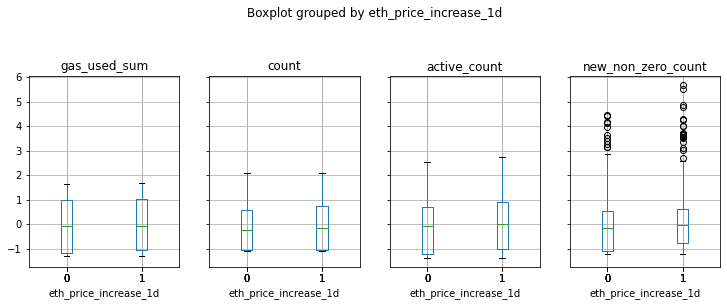

In [216]:
eth_df_norm.boxplot(column = column_list, by = 'eth_price_increase_1d', layout=(3,4), figsize=(12,12))

Based on the boxplots above, we can get a rough sense for which variables have the biggest effect on eth_price_increase_1d. To do this, we can look at the boxes for a predictor to see how the quantiles (25%, 50%, 75%) differ between the two subsets: eth_price_increase_1d = 1 and eth_price_increase_1d = 0. If each of these quantiles is similar, so that the two boxes have the same top, green line, and bottom, then the predictor probably doesn't have much effect on eth_price_increase_1d. But if some or all of these aspects of the box are very different from each other, then the predictor likely has a bigger effect.

Unfortunately it seems as though these predictors aren't very powerful in classifying eth_price_increase_1d. Let's answer this quantitatively using another logistic regression model or even different time frames.

Predicting price increases on financial datasets using simple logistic classification is incredibely difficult. The usefulness of these boxplots would increase if was predicting something else like the classic diabetes dataset or weather dataset.

In [221]:
eth_price_increased_1d = eth_df['eth_price_increase_1d']
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_price_increased_1d
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1756 rows 
Test Set: 753 rows


In [222]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [223]:
#Printing accuracy score and classification report
accuracy(y_test,preds)

The accuracy score is: 51.9%
              precision    recall  f1-score   support

           0       0.49      0.64      0.56       356
           1       0.56      0.41      0.47       397

    accuracy                           0.52       753
   macro avg       0.53      0.53      0.52       753
weighted avg       0.53      0.52      0.51       753

confusion matrix: 
[[229 127]
 [235 162]]
P(y):
[[0.51052085 0.48947915]
 [0.50994454 0.49005546]
 [0.52178377 0.47821623]
 ...
 [0.51408057 0.48591943]
 [0.51795605 0.48204395]
 [0.50082868 0.49917132]]
AUC: 
0.541


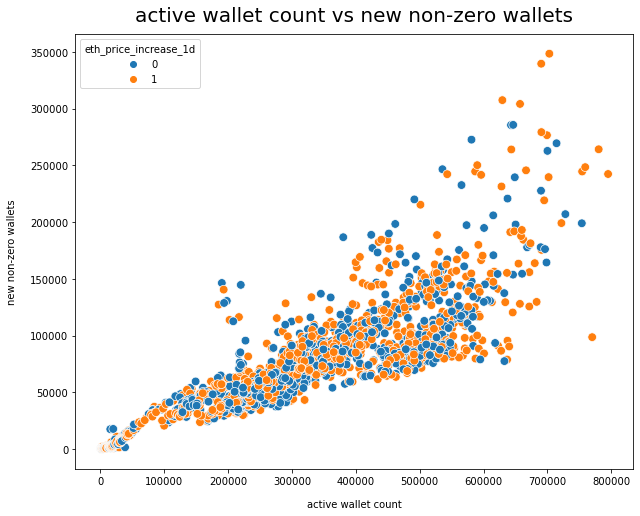

In [224]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_1d', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

### Normalized Data for Logistic model 
The normalized data for the predictors seemed to have made it so our model does predict 1's (increases) and 0's (decreases). Let's try this with different time frames: 7d, 1m, 3m. 

### 7 Day TimeFrame

In [228]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_7d']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')


Training Set: 1756 rows 
Test Set: 753 rows


In [229]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [230]:
#Printing accuracy score, classification report, and confusion matrix
accuracy(y_test, preds)

The accuracy score is: 56.8%
              precision    recall  f1-score   support

           0       0.53      0.75      0.62       358
           1       0.64      0.40      0.49       395

    accuracy                           0.57       753
   macro avg       0.59      0.58      0.56       753
weighted avg       0.59      0.57      0.56       753

confusion matrix: 
[[269  89]
 [236 159]]
P(y):
[[0.51525788 0.48474212]
 [0.45456774 0.54543226]
 [0.51443113 0.48556887]
 ...
 [0.36605775 0.63394225]
 [0.52598056 0.47401944]
 [0.50369432 0.49630568]]
AUC: 
0.604


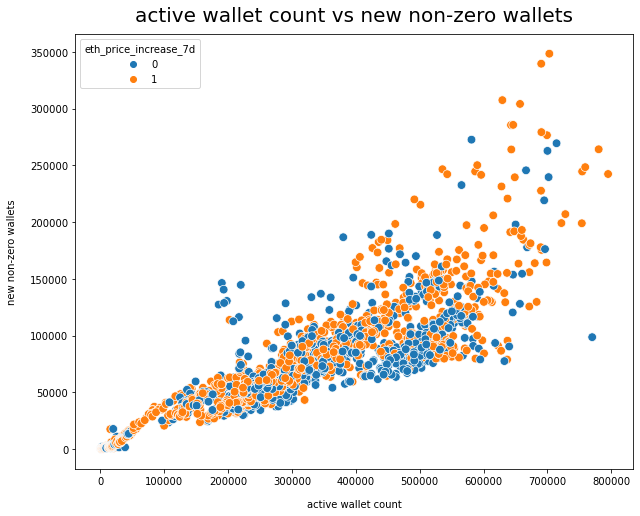

In [231]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_7d', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

### 1 Month TimeFrame

In [232]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_1m']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')


Training Set: 1756 rows 
Test Set: 753 rows


In [233]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy(y_test, preds)

The accuracy score is: 89.2%
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       340
           1       0.89      0.92      0.90       413

    accuracy                           0.89       753
   macro avg       0.89      0.89      0.89       753
weighted avg       0.89      0.89      0.89       753

confusion matrix: 
[[294  46]
 [ 35 378]]
P(y):
[[0.05 0.95]
 [0.   1.  ]
 [0.06 0.94]
 ...
 [0.26 0.74]
 [0.25 0.75]
 [1.   0.  ]]
AUC: 
0.954


In [234]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [235]:
#Printing accuracy score and classification report
accuracy(y_test, preds)

The accuracy score is: 62.5%
              precision    recall  f1-score   support

           0       0.56      0.76      0.65       340
           1       0.72      0.52      0.60       413

    accuracy                           0.63       753
   macro avg       0.64      0.64      0.62       753
weighted avg       0.65      0.63      0.62       753

confusion matrix: 
[[258  82]
 [200 213]]
P(y):
[[0.55030354 0.44969646]
 [0.40935396 0.59064604]
 [0.56234809 0.43765191]
 ...
 [0.55301954 0.44698046]
 [0.54456063 0.45543937]
 [0.55012179 0.44987821]]
AUC: 
0.694


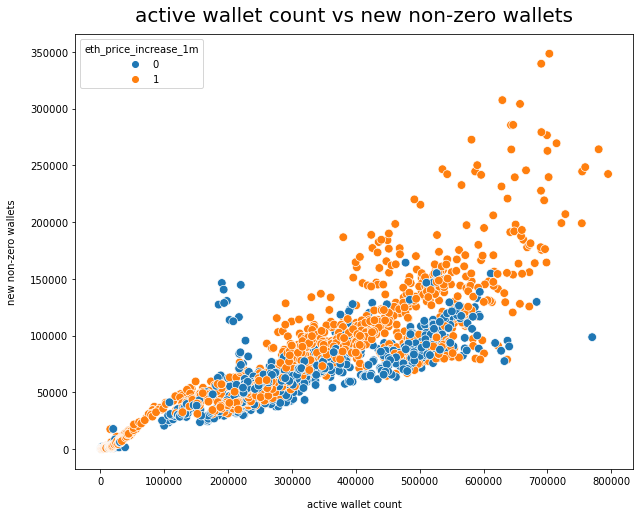

In [236]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_1m', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

### 3 Month TimeFrame

In [237]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_3m']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')


Training Set: 1756 rows 
Test Set: 753 rows


In [238]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [239]:
#Printing accuracy score and classification report
accuracy(y_test, preds)

The accuracy score is: 64.7%
              precision    recall  f1-score   support

           0       0.53      0.78      0.63       292
           1       0.80      0.56      0.66       461

    accuracy                           0.65       753
   macro avg       0.67      0.67      0.65       753
weighted avg       0.70      0.65      0.65       753

confusion matrix: 
[[229  63]
 [203 258]]
P(y):
[[0.28892592 0.71107408]
 [0.09419614 0.90580386]
 [0.6159619  0.3840381 ]
 ...
 [0.60422549 0.39577451]
 [0.0075812  0.9924188 ]
 [0.46888482 0.53111518]]
AUC: 
0.732


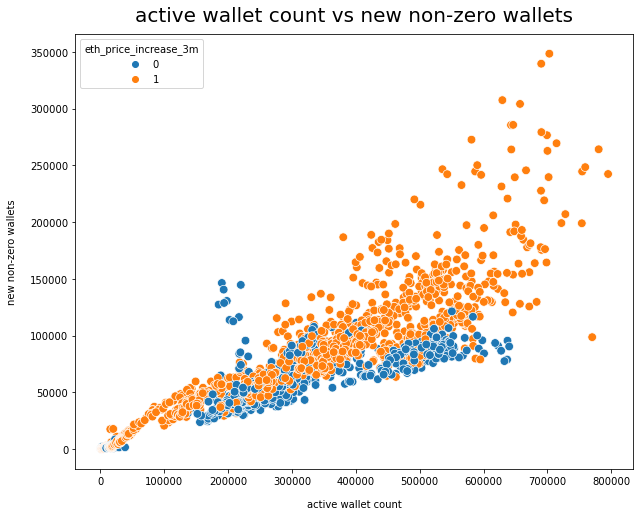

In [240]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_3m', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

## Issues + Observations

- The issues with using this model as a method to trade is that eth_price_increase_timeframe is only strictly greater than 0. However, the relationship between loses and gains is reciprocal. 
    - %Gain to restore loss = [1/(1-%loss)]-1
- Thus the gain that is required to offset loss quickly becomes significantly larger.
- Additionally, we seem to have increased accuracy when we extend the timeframe. 
- In the upper right portion where active wallet count is above 650,000 and new non-zero count is above 125,000 we see that eth is strictly bullish over a 3 month time period. This could be used to fuel in investment strategy. 
- Even when active wallets is relatively low, eth can be bullish in this timeframe from a high number of non-zero wallets. However, if active wallet count is too low the influx of new non-zero wallets may not be enough to spur eth price growth.

## Larger Timeframes: 6m, 1y

In [241]:
#Adding 6 month binary increase or decrease
diff_eth_price_6m = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(180)
eth_price_increase_6m = diff_eth_price_6m > 0
eth_df['eth_price_increase_6m'] = eth_price_increase_6m.astype(int)

#Adding 1 year binary increase or decrease
diff_eth_price_1y = eth_df['price_usd_close'] - eth_df['price_usd_close'].shift(360)
eth_price_increase_1y = diff_eth_price_1y > 0
eth_df['eth_price_increase_1y'] = eth_price_increase_1y.astype(int)

In [242]:
eth_df.tail(2)

,count,active_count,new_non_zero_count,gas_used_sum,price_usd_close,eth_price_increase_1d,eth_price_increase_7d,eth_price_increase_1m,eth_price_increase_3m,eth_price_increase_6m,eth_price_increase_1y
t,,,,,,,,,,,
2022-06-19,154861838.0,434371.0,61569.0,8.805410e+10,1126.475029,1,0,0,0,0,0
2022-06-20,154927479.0,443537.0,65641.0,9.040232e+10,1129.769154,1,0,0,0,0,0


In [246]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_6m']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1756 rows 
Test Set: 753 rows


In [247]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [248]:
accuracy(y_test, preds)

The accuracy score is: 70.0%
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       265
           1       0.85      0.65      0.74       488

    accuracy                           0.70       753
   macro avg       0.70      0.72      0.69       753
weighted avg       0.75      0.70      0.71       753

confusion matrix: 
[[211  54]
 [172 316]]
P(y):
[[0.22721329 0.77278671]
 [0.71150432 0.28849568]
 [0.41551876 0.58448124]
 ...
 [0.1551325  0.8448675 ]
 [0.20538628 0.79461372]
 [0.3343766  0.6656234 ]]
AUC: 
0.771


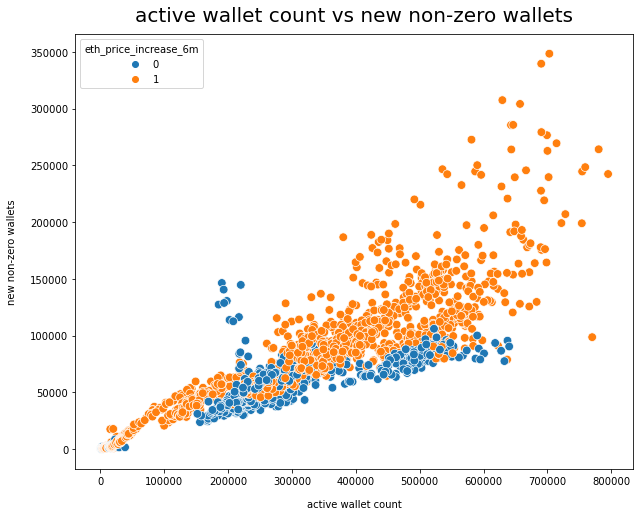

In [249]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_6m', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

## Random Forest Classifier for 6 month

In [250]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_6m']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1756 rows 
Test Set: 753 rows


In [251]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [252]:
accuracy(y_test, preds)

The accuracy score is: 97.3%
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       257
           1       0.98      0.98      0.98       496

    accuracy                           0.97       753
   macro avg       0.97      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753

confusion matrix: 
[[247  10]
 [ 10 486]]
P(y):
[[0.   1.  ]
 [0.9  0.1 ]
 [0.   1.  ]
 ...
 [0.   1.  ]
 [0.64 0.36]
 [0.   1.  ]]
AUC: 
0.997


This Random Ofrest Classifier is scary accurate. Previous work with regression models also showed the greatest efficacy with random forest models. This is further corroborated by Dr. Ernest Chan [here.](https://www.youtube.com/watch?v=BhaJVZNpL4M&t=2894s)

## 1 Year Timeframe

In [253]:
#Same syntax as earlier, just using normalized predictors.
X = eth_df_norm[['gas_used_sum','count','active_count','new_non_zero_count']]
X, y = X, eth_df['eth_price_increase_1y']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30)
print (f'Training Set: {X_train.shape[0]} rows \nTest Set: {X_test.shape[0]} rows')

Training Set: 1756 rows 
Test Set: 753 rows


In [254]:
#Fitting Logistic Regression Model & Predicted y_test vs actuals
model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [255]:
accuracy(y_test, preds)

The accuracy score is: 68.5%
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       281
           1       0.80      0.66      0.73       472

    accuracy                           0.69       753
   macro avg       0.68      0.69      0.68       753
weighted avg       0.71      0.69      0.69       753

confusion matrix: 
[[203  78]
 [159 313]]
P(y):
[[0.76944304 0.23055696]
 [0.3382498  0.6617502 ]
 [0.34761651 0.65238349]
 ...
 [0.44917046 0.55082954]
 [0.3011351  0.6988649 ]
 [0.76741247 0.23258753]]
AUC: 
0.784


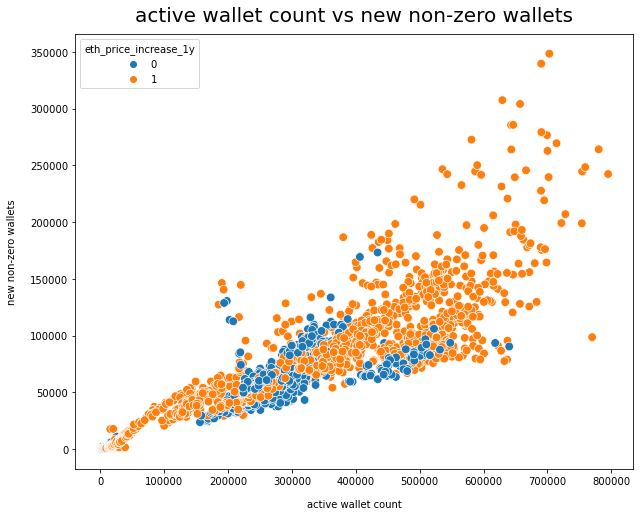

In [256]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='active_count', y='new_non_zero_count', hue='eth_price_increase_1y', data=eth_df, s=75)
plt.title("active wallet count vs new non-zero wallets", y=1.015, fontsize=20)
plt.xlabel("active wallet count", labelpad=13)
plt.ylabel("new non-zero wallets", labelpad=13)
ax = plt.gca()

## Comments on 6m, 1y timeframes:
- The classification models accuracy increased generally as the time frames increased. 
- Random Forest Algorithms seem to work best when it comes to financial data and predicting continious or binary outputs. 
- Given the short timespan in eth has been around and insane price appreciation, it would be quite unlikely that there are very many instances of eth declining in price for a year. These instances would likely occur after a blow off top where it may take more than 1 year to regain the price it had during such a speculative moment. 

# Takeaways:
- Random forest algorithms seem to be best for predicting priced time-series data.
- Could always use other logistic classification algorithms.
- Normalizing data can be very very useful for data that has a large range of values. Completely fixed the intial model.
- Make sure to validate there is no multi-collinearity between the independent variables. In this model, I would presume that active wallets and non-zero wallets will overlap when intially creating new wallet, funding it, and interacting on the ethereum blockchain. 

## Further Applications of Classification on Price Data
- I would like to see certain percentage increases embedded into predictions. Multiclass classification could work for this. Something along the lines of 5% increase & decrease, and 10% increase and decrease.
- Further implementing the relationship of gain% to loss% column.